In [1]:
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import sqlite3
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans 

# Liste des fonctions

## f_requete_sql - Requete SQL

In [2]:
def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

## f_clusters_transform - Fonction conversion df en np.array

In [3]:
def f_clusters_transform (df):
    """
    df : dataframe pandas
    """
    data = df.values.T
    names = df.columns
    return(data, names)

## f_clusters_coude - Fonction d'affichage de l'inertie en fonction du nombre de clusters

In [4]:
def f_clusters_coude (df, k_max:int=15):
    """
    k_max : entier représentant le nombre max de clusters à tracer
    """
    data, names = f_clusters_transform(df)
    Sum_of_squared_distances = [] 
    K = range(1,30) 
    for k in K : 
        km = KMeans(n_clusters=k) 
        km = km.fit(data) 
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-') 
    plt.xlabel('k') 
    plt.ylabel('Sum_of_squared_distances') 
    plt.title('Méthode du coude pour k optimal') 
    plt.show()

## f_clusters_fit - Fonction entrainement du modèle, retour des labels et profils clusters

In [5]:
def f_clusters_fit (df, k:int = 4, n_init:int = 200, max_iter:int = 1000):
    """
    Entrainement et affichage de la distribution dans les clusters
    return :
    - cluster_table : df bss - cluster - r2
    - df_clusters_centers : df série temporelle des clusters
    """
    data, names = f_clusters_transform (df)
    km = KMeans(n_clusters=k, n_init=200, max_iter=1000)
    # Entraînement du modèle
    km.fit(data)
    # Définition des numéros de cluster
    labels = km.labels_+1
    # Profils des clusters
    cluster_centers = np.array(km.cluster_centers_)
    df_cluster_centers = pd.DataFrame(cluster_centers.T, index=df.index)
    for cluster in range(df_cluster_centers.shape[1]):
        df_cluster_centers.rename(columns = {cluster:f"cluster_{cluster+1}"}, inplace=True)
    
    # Création du dataframe de résultats
    cluster_table = pd.DataFrame()
    cluster_table["code_bss"] = names
    cluster_table.set_index("code_bss", inplace=True)
    cluster_table["cluster"] = labels
    for piezo in cluster_table.index :
        cluster_table.loc[piezo, "r2"] = r2_score(df.loc[:,piezo], cluster_centers[cluster_table.loc[piezo, "cluster"]-1])
    
    return cluster_table, df_cluster_centers

## f_plot_clusters - Fonction d'affichage des chroniques par cluster

In [6]:
def f_plot_clusters (df, cluster_table, cluster_centers):
    
    data, names = f_clusters_transform (df)
    
    labels = cluster_table["cluster"]
    
    fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,25))
    row_i=0

    for label in set(labels):
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i].plot(df.iloc[:,i],alpha=0.4)

        axs[row_i].plot(cluster_centers.iloc[:,label-1],c="red")
        axs[row_i].set_title("Cluster "+str(row_i+1))
        row_i+=1
    plt.show()

## f_plot_all - Fonction d'affichage individuel des chroniques et leur cluster associé

In [7]:
def f_plot_all (df, cluster_table, df_cluster_centers) :

    data, names = f_clusters_transform (df)

    if df.shape[1]%4 == 0:
        nbre_lignes = df.shape[1]//4
    else : 
        nbre_lignes = df.shape[1]//4 + 1

    fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
    #fig.suptitle('Series')
    for i in range(nbre_lignes):
        for j in range(4):
            if i*4+j+1>df.shape[1]: # pass the others that we can't fill
                continue
            axs[i, j].plot(df.iloc[:,i*4+j])
            axs[i, j].plot(df_cluster_centers.iloc[:,cluster_table.iloc[i*4+j,0]-1])
            
            axs[i, j].set_title(df.columns[i*4+j] + f" - r² = {round(cluster_table.loc[df.columns[i*4+j],'r2'],2)}")
            
    plt.show()

## f_r2min - Fonction de calcul du seuil minimal r2

In [8]:
def f_r2min (cluster_table):
    # Calcul de r2min

    Q1 = cluster_table["r2"].quantile(0.25, "higher")
    Q3 = cluster_table["r2"].quantile(0.75, "lower")

    # Ecart inter-quartile
    IQM = (Q3-Q1)

    # Seuil minimal de conservation des chroniques (Q1-1.5*IQM)

    r2min = Q1-1.5*IQM
    return r2min

# Exploitation - 1ère passe

## Chargement des données

In [58]:
region = "CVL"

# Import du csv et conversion en dataframe
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
data = pd.read_csv(f"./data/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

## Analyse du nombre optimal de clusters

C:\Users\daranlot\Anaconda3\envs\Environnement\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


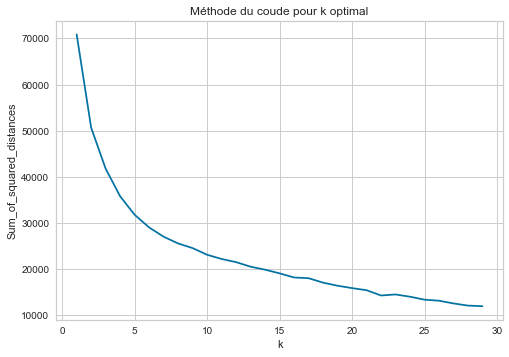

In [59]:
f_clusters_coude(data)

## Création des clusters

In [ ]:
nbre_clusters = 6

In [ ]:
cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, 500, 5000)

In [ ]:
sns.countplot(cluster_table.cluster)

In [ ]:
# On renomme les noms de cluster par rapport à la région
for index, column in enumerate (cluster_centers.columns):
    print(index, column)
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)

In [ ]:
cluster_table.head()

## Affichage des clusters

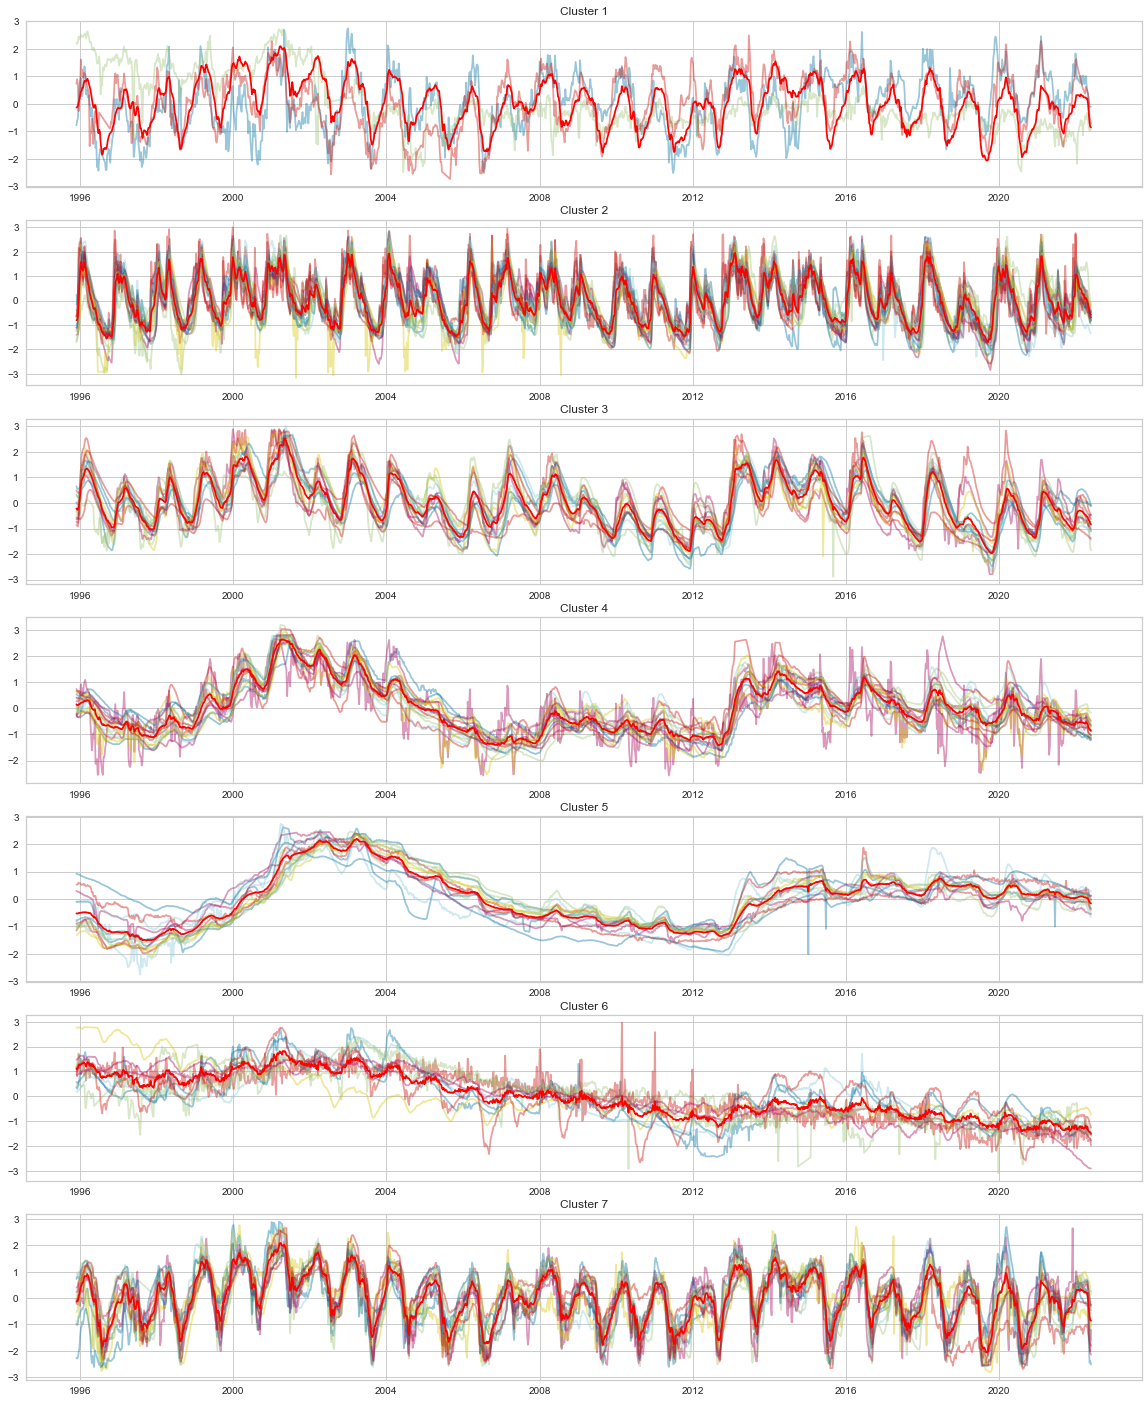

In [60]:
f_plot_clusters(data, cluster_table, cluster_centers)

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


tab, names = f_clusters_transform(data)


# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(tab) + (nbre_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=nbre_clusters, random_state=2022)
cluster_labels = clusterer.fit_predict(tab)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(tab, cluster_labels)
print(
    "For n_clusters =",
    nbre_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(tab, cluster_labels)

y_lower = 10
for i in range(nbre_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / nbre_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / nbre_clusters)
ax2.scatter(
    tab[:, 0], tab[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % nbre_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

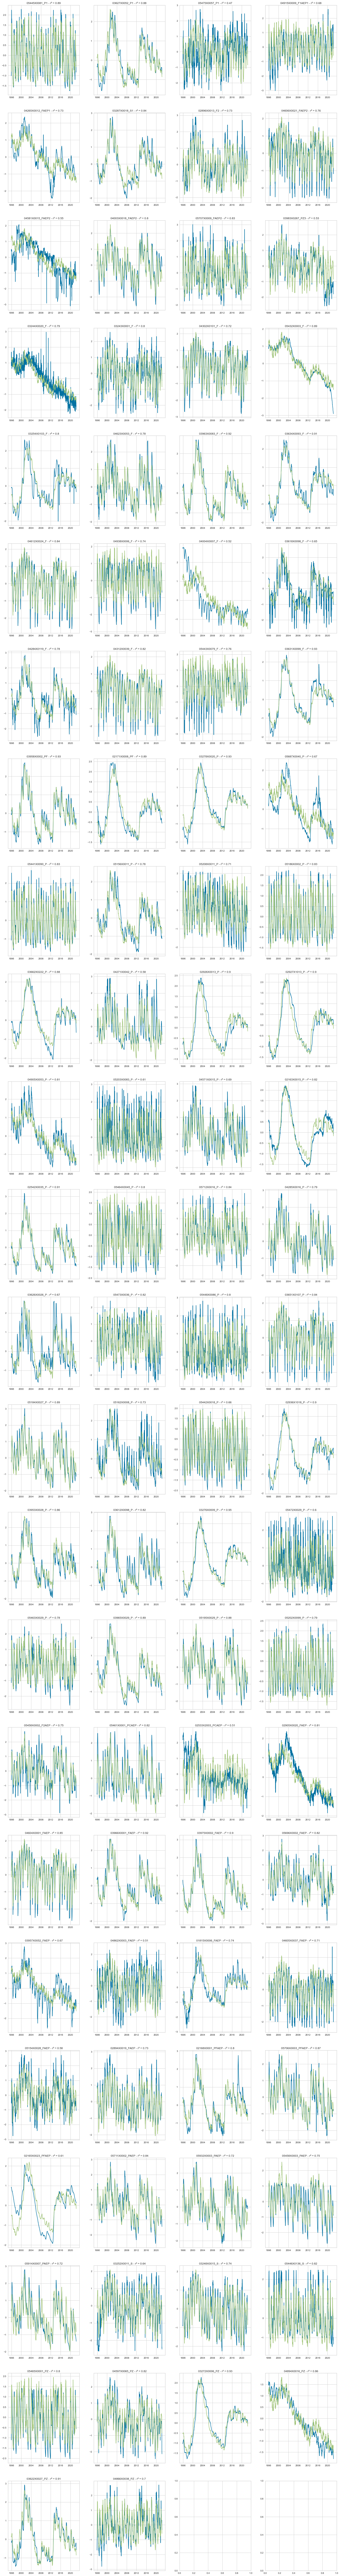

In [61]:
f_plot_all(data, cluster_table, cluster_centers)

## Analyse r2

In [ ]:
plt.plot(cluster_table["r2"].sort_values())

## Filtre des chroniques avec score insuffisant

In [ ]:
# nbre de chroniques sous le seuil
r2min = f_r2min(cluster_table)
nbre_elim = cluster_table.loc[cluster_table.r2 < r2min, 'r2'].count()
iteration = 1

while nbre_elim != 0 :
    # chroniques sous le seuil passées à cluster 0
    r2min = f_r2min(cluster_table)
    cluster_table.loc[cluster_table.r2 < r2min, "cluster"] = 0
    
    # Selection des clusters non zéro
    data = data.loc[:,cluster_table.loc[cluster_table.cluster != 0].index]
    
    # Nouveau clustering
    cluster_table, cluster_centers, km = f_clusters_fit(data, nbre_clusters, 500, 5000)
    
    nbre_elim = cluster_table.loc[cluster_table.r2 < r2min, 'r2'].count()
    
    print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")
    iteration += 1
    

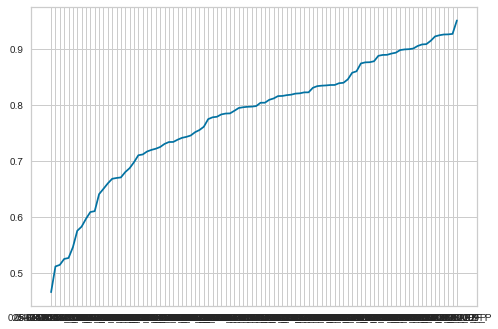

In [62]:
plt.plot(cluster_table["r2"].sort_values())

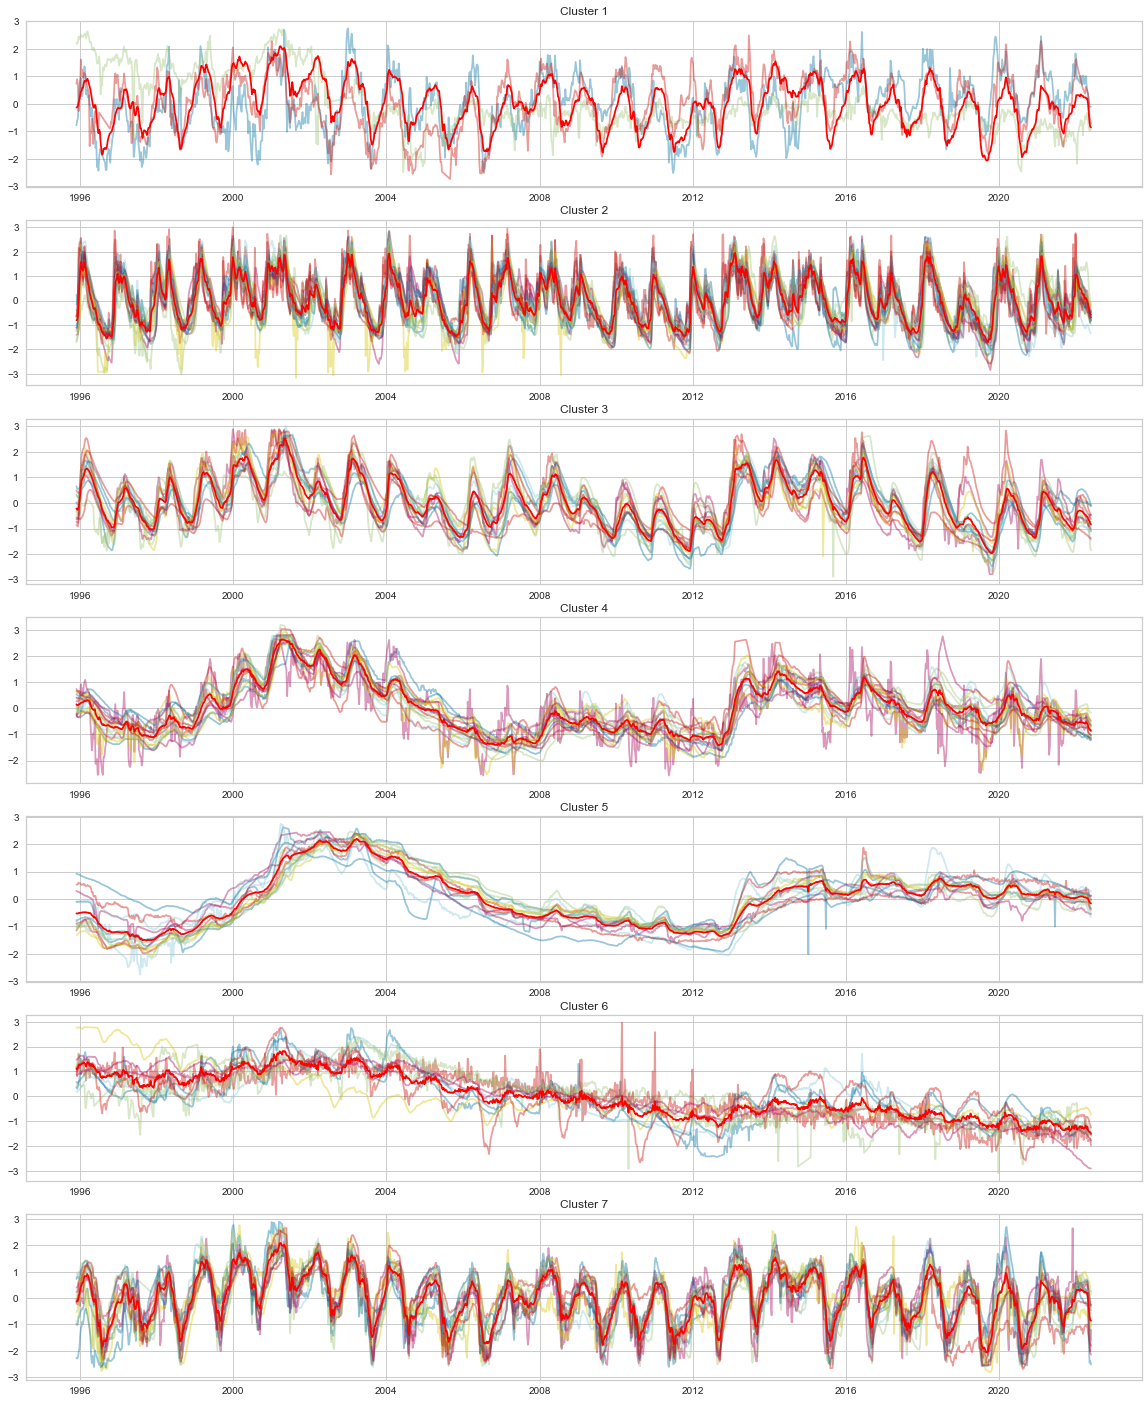

In [63]:
f_plot_clusters(data, cluster_table, cluster_centers)

In [64]:
cluster_table.head()

cluster        r2
code_bss                            
05445X0081_P1            1  0.888361
03627X0052_P1            3  0.878610
05475X0057_P1            0  0.465439
04915X0009_F1AEP1        1  0.680413
04265X0012_FAEP1         5  0.725246

In [65]:
cluster_table.shape

(94, 2)

In [66]:
cluster_table.groupby("cluster").mean()

r2
cluster          
0        0.497108
1        0.764101
2        0.778892
3        0.834346
4        0.862769
5        0.729356
6        0.740280

# Prédiction des autres piezos

In [67]:
region = "CVL"

Récupération de l'ensemble des codes_bss de la région depuis la base de données. 

In [68]:
requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """

In [ ]:
requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND cluster_sklearn_kmeans_5_v1 IS NOT NULL
         """

code_bss = [code[0] for code in f_requete_sql(requete)]

    
# Les chroniques des piezos sont assemblées en un dataframe Pandas.

directory = '../data/piezo/'

print(f"Création du dataframe avec {len(code_bss)} piézomètres.")

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)
# Mise en forme de la date en Y - W
data.index = data.index.strftime("%Y - S%W")
# Moyenne des mesures pour une même semaine
data = pd.DataFrame(data.groupby("date_mesure").mean())

print(f"Chargement des données à partir des fichiers csv.")

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    # Mise en forme de la date en Y - W
    df.index = df.index.strftime("%Y - S%W")
    # Moyenne des mesures pour une même semaine
    df = pd.DataFrame(df.groupby("date_mesure").mean())
    data = pd.merge(data, df, left_index=True, right_index=True, how='outer')
    data = data.interpolate()

print(f"Suppression des valeurs abbérantes.")   
    
# Suppression des valeurs abbérantes
for piezo in data.columns : 
    q1 = np.nanquantile(data[f"{piezo}"], .25)
    q3 = np.nanquantile(data[f"{piezo}"], .75)
    IQR = q3-q1
    data.loc[data[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data.loc[data[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    
print(f"Normalisation des données.")    

# Normalisation

def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

scaler = StandardScaler()
data = scaleColumns(data)

print("Création du dataframe de résultats.")

big_clustering = pd.DataFrame(index=data.columns, columns=["cluster"])

# Mise en forme des chroniques calculées des clusters au même format Y - W

cluster_centers_S = cluster_centers.copy()
cluster_centers_S.index = cluster_centers_S.index.strftime("%Y - S%W")

print("Entrainement et clusterisation en cours.")

# Initialisation du modèle
# random_state permet de conserver le même ordre de sortie des labels pour l'entrainement
knn =  KMeans(n_clusters=nbre_clusters, n_init=200, max_iter=1000, random_state=2022)

# Pour chaque piézo, une jointure interne est réalisée entre la chronique du piezo (sans les NaN) et les chroniques calculées 
for piezo in data.columns:
    df_merge = pd.DataFrame()
    df_merge = pd.merge(data[piezo].dropna(), cluster_centers_S, how='inner', left_index=True, right_index=True)
    # Interpolation en cas de caleurs manquantes
    df_merge = df_merge.interpolate('linear')
    # Transformation en tableau numpy et récupération des codes_bss
    X, names = f_clusters_transform(df_merge)
    # Entrainement du modèle
    knn.fit(X[1:])
    # Prédiction sur les données du piezo
    y = X[0].reshape(1,-1)
    big_clustering.loc[piezo,"cluster"] = f"{region}_{knn.predict(y)[0]+1}"

print("====== Clusterisation terminée ======")

In [ ]:
cluster_centers_S

In [ ]:
f_plot_clusters(data, big_clustering, cluster_centers_S)

In [ ]:
labels = big_clustering["cluster"]

fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,25))
row_i=0

for label in set(labels):
    for i in range(len(labels)):
        if(labels[i]==label):
            axs[row_i].plot(data.iloc[:,i],alpha=0.4)

    axs[row_i].plot(cluster_centers_S.iloc[:,int(label[-1])-1],c="red")
    axs[row_i].set_title("Cluster "+str(row_i+1))
    row_i+=1
plt.show()

# Ajout à la bdd

In [ ]:
requete = """
                    ALTER TABLE data_piezo
                    ADD cluster_kmeans_ALL VARCHAR(6) DEFAULT NULL
                    """
f_requete_sql(requete)

In [ ]:
# Création de listes de nuéro de cluster avec le nom des piezos
# Ajout dans la bdd
for label in set(big_clustering.cluster):
    exec(f"cluster = tuple(big_clustering.loc[big_clustering.cluster == '{label}', 'cluster'].index.to_list())")
    requete = f"""
        UPDATE data_piezo
        SET cluster_kmeans_ALL = '{label}'
        WHERE code_bss IN {cluster}
        """
    f_requete_sql(requete)

In [ ]:
clus

In [ ]:
set(big_clustering.cluster)

## Suppresion colonne

In [ ]:
requete = """
                    ALTER TABLE data_piezo
                    DROP cluster_kmeans_ALL
                    """
f_requete_sql(requete)